### Prepare radiation input for discretization ####
Calculate average daily radiation over the snow-melting period. This step includes:
1. calculate daily radiation based on dem, slope, aspect and the day of year (DOY). One output per DOY.
2. calculate the period mean daily radiation.
3. check the correctness of radiation.<br>

Note that it is better to run this code on high-performance computers because the 1st step is time-and-memory comsuming.

In [3]:
# import libraries
import os, shutil, sys
sys.path.append('../')
import functions.utils as ut
import geopandas as gpd
import rasterio as rio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline

In [8]:
# common paths
control_file    = '../control_Utah.txt'
basin_data_path = ut.read_from_control(control_file, 'basin_data_path')
basin_name      = ut.read_from_control(control_file, 'basin_name')
gis_path        = os.path.join(basin_data_path, 'gis')
main_path       = ut.read_from_control(control_file, 'main_path')
tmpfile_path    = ut.read_from_control(control_file, 'tmpfile_path')
if not os.path.exists(tmpfile_path):
    os.makedirs(tmpfile_path)
plot_path       = os.path.join(basin_data_path, 'plots')

In [5]:
# define equal area projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [6]:
# basin datafiles
basin_gru_shp          = ut.set_filename(control_file, 'basin_gru_shp') 
basin_flowlines_shp    = ut.set_filename(control_file, 'basin_flowlines_shp')
basin_dem_raster       = ut.set_filename(control_file, 'basin_dem_raster')  
basin_slope_raster     = ut.set_filename(control_file, 'basin_slope_raster')  
basin_aspect_raster    = ut.set_filename(control_file, 'basin_aspect_raster')
basin_radiation_raster = ut.set_filename(control_file, 'basin_radiation_raster')

# drived files
basin_gru_prj_shp      = os.path.join(gis_path, os.path.basename(basin_gru_shp).split('.shp')[0]+'_prj.shp') 

#### Define radiation calcultion configurations ####

In [5]:
# path to store daily radiation. One output per DOY. 
srad_output_dir = os.path.join(basin_data_path, 'radiation_doy/')
if not os.path.exists(srad_output_dir):
    os.makedirs(srad_output_dir)
    
# path to store job submission files.    
command_dir = os.path.join(basin_data_path, 'radiation_doy_commands/')
if os.path.exists(command_dir):
    shutil.rmtree(command_dir) 
os.makedirs(command_dir)

In [6]:
# code to calculate daily radiation. Copy this code to the command folder for use later.
# This calculation code is based on the reference:Allen, R.G., Trezza, R. and Tasumi, M., 2006. 
# Analytical integrated functions for daily solar radiation on slopes. Agricultural and Forest Meteorology, 139(1-2), pp.55-73.

script_file = '../functions/calculate_radiation.py'
abs_script_file = os.path.abspath(script_file) # absolute file path

#### 1. Calculate daily radiation over a evaluation period ####
If users run this on a local machine, daily radiation is calculated day-by-day. Therefore, the entire process may take a long time depending on the doamin size and period length. In contrast, if user runs this on a high-performance cluster, daily radiaiton is calculated via jobs, and all jobs can be run simutanously, which saves time.

In [7]:
# create job submission files for radiation calculation

# first set radiation calculation period
solrad_start_DOY = ut.read_from_control(control_file, 'solrad_start_DOY') 
solrad_end_DOY   = ut.read_from_control(control_file, 'solrad_end_DOY') 
ndays            = int(solrad_end_DOY) - int(solrad_start_DOY) + 1   # number of days in radiation calculation period

# calculate 1 radiation estimate per week in period
for i in tqdm(np.arange(0,ndays+4,7)):
    DOY = int(solrad_start_DOY) + i
    command_filename = os.path.join(command_dir,'sbatch_DOY'+str(DOY)+'.sh')
    print(command_filename)
    if os.path.exists(command_filename):
        os.remove(command_filename)

    # ------------------------------------------------------------------
    # cluster submission settings: [cheyenne]
    with open(command_filename,'w') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH --job-name=SwDOY'+str(DOY)+'\n')
        f.write('#SBATCH --account=def-h294liu\n')
        f.write('#SBATCH --time=00:30:00\n')
        f.write('#SBATCH --mem=5G\n')
        f.write('#SBATCH --output=%x-%j.out\n') 
                
        #f.write('module load peak_memusage\n\n') # monitor peak memory usage   
        # Note: cheyenne usable memory per compute node is ~45GB.        
#         # load python environment
#         f.write('source /etc/profile.d/modules.csh\n')
#         f.write('module reset\n')
#         f.write('module load python/3.6.8\n')
#         f.write('source /glade/u/apps/opt/ncar_pylib/ncar_pylib.csh\n\n')

        # To put both single quotes and double quotes inside of a string, wrap the string in triple quotes.
        #f.write("""peak_memusage.exe %s %s %s %s %s %s %d %s\n"""%\
        f.write("%s %s %s %s %s %s %d %s\n" % 
                ('python',
                 abs_script_file, basin_dem_raster, basin_slope_raster, basin_aspect_raster,
                 str(DOY), int(new_epsg), srad_output_dir))                

100%|██████████| 14/14 [00:00<00:00, 3256.45it/s]

/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY75.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY82.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY89.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY96.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY103.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY110.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY117.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY124.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY131.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY138.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY145.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY152.sh
/Users/hongliliu/Documents/tmp/utah/radiation_doy_commands/sbatch_DOY159.sh
/Users/hongliliu

In [8]:
# submit jobs, one per day in range (or run consecutively)
# for large domains (more than a few square degrees, submission is likely faster; otherwise sequential may be fine)
current_dir = os.getcwd()
os.chdir(command_dir)
for i in tqdm(np.arange(0,ndays+4,7)):
    DOY = int(solrad_start_DOY) + i

    # option 1: run via cluster jobs
    # command_filename = os.path.join(command_dir,'sbatch_DOY'+str(DOY)+'.sh')
    # os.system('sbatch ' + command_filename)

    # option 2: run on current computer
    command_filename = 'sbatch_DOY'+str(DOY)+'.sh'
    os.system('chmod 744 '+command_filename)    
    os.system('./'+command_filename)
    print(command_filename)
    
os.chdir(current_dir)

  7%|▋         | 1/14 [00:02<00:28,  2.15s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY75.sh


 14%|█▍        | 2/14 [00:04<00:25,  2.10s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY82.sh


 21%|██▏       | 3/14 [00:06<00:23,  2.14s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY89.sh


 29%|██▊       | 4/14 [00:08<00:22,  2.24s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY96.sh


 36%|███▌      | 5/14 [00:11<00:20,  2.26s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY103.sh


 43%|████▎     | 6/14 [00:13<00:17,  2.22s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY110.sh


 50%|█████     | 7/14 [00:15<00:15,  2.24s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY117.sh


 57%|█████▋    | 8/14 [00:17<00:13,  2.30s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY124.sh


 64%|██████▍   | 9/14 [00:20<00:11,  2.25s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY131.sh


 71%|███████▏  | 10/14 [00:22<00:09,  2.31s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY138.sh


 79%|███████▊  | 11/14 [00:24<00:06,  2.32s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY145.sh


 86%|████████▌ | 12/14 [00:27<00:04,  2.30s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY152.sh


 93%|█████████▎| 13/14 [00:29<00:02,  2.34s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY159.sh


100%|██████████| 14/14 [00:31<00:00,  2.28s/it]

read inputs
derive latitude
calculate Sw
INTEGRATION LIMITS
CALCULATE EXTRATERRESTRIAL RADIATION
CLEAR SKY SOLAR RADIATION
save Sw raster
Done
sbatch_DOY166.sh


#### 2. Calculate average daily radiation ####

In [9]:
# read daily radiation over the period and calculate the period mean
ndays_eff = len(np.arange(0,ndays+4,7))  # number of days that will be averaged at weekly frequency
for i in np.arange(0,ndays+4,7):
    DOY           = int(solrad_start_DOY) + i
    sw_DOY_raster = os.path.join(srad_output_dir,'sw_DOY'+str(DOY)+'.tif')

    # read DOY radiation 
    with rio.open(sw_DOY_raster) as ff:
        sw         = ff.read(1)
        mask       = ff.read_masks(1)
        sw_ma      = np.ma.masked_array(sw, mask==0)
        out_meta   = ff.meta.copy()
        nodatavals = ff.nodatavals
        
    # create matching 2D array to sum up DOY radiation (creating the mean)
    if i == 0:
        sw_avg = sw_ma * 0
    
    # update value with prorated addition of each new day in period
    sw_avg = sw_avg + (sw_ma/ndays_eff)

# save to raster
sw_avg_value = sw_avg.filled(fill_value=nodatavals)  # return a copy of self, with masked values filled with a given value.
sw_avg_ma    = np.ma.masked_array(sw_avg_value, mask==0) # assign mask from sw_DOY
sw_avg_ma    = sw_avg_ma.astype(sw_ma.dtype)           # change data type to sw_ma's.
with rio.open(basin_radiation_raster, 'w', **out_meta) as outf:
    outf.write(sw_avg_ma, 1)   

#### 3a. Check CDF of average daily radiation ####

<Figure size 640x480 with 0 Axes>

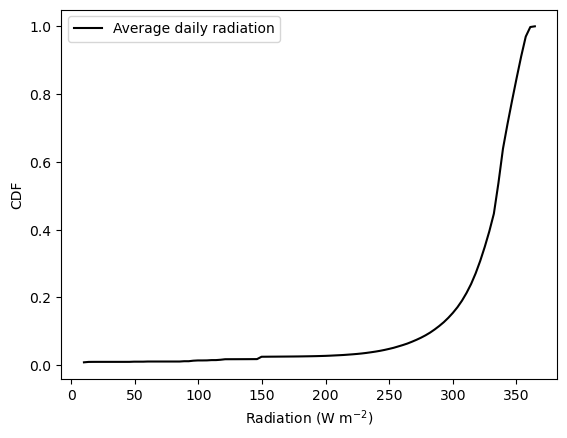

In [11]:
# Choose how many bins you want here
num_bins = 100

# raw sw and its area-based cdf
with rio.open(basin_radiation_raster) as ff:
    sw   = ff.read(1)
    mask = ff.read_masks(1)
origin_counts, origin_bin_edges = np.histogram(sw[mask!=0], bins=num_bins)

cum_counts  = np.cumsum(origin_counts)
total_count = cum_counts[-1]
origin_cdf  = cum_counts/float(total_count)

# Plot comparatives cdf
plt.clf()
fig, ax = plt.subplots()
ax.plot(origin_bin_edges[1:], origin_cdf, '-k', label='Average daily radiation')
plt.xlabel("Radiation (W m$^{-2}$)")
plt.ylabel("CDF")
plt.legend(loc='best')
plt.show()

#### 3b. Check distribution of average daily radiation ###

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

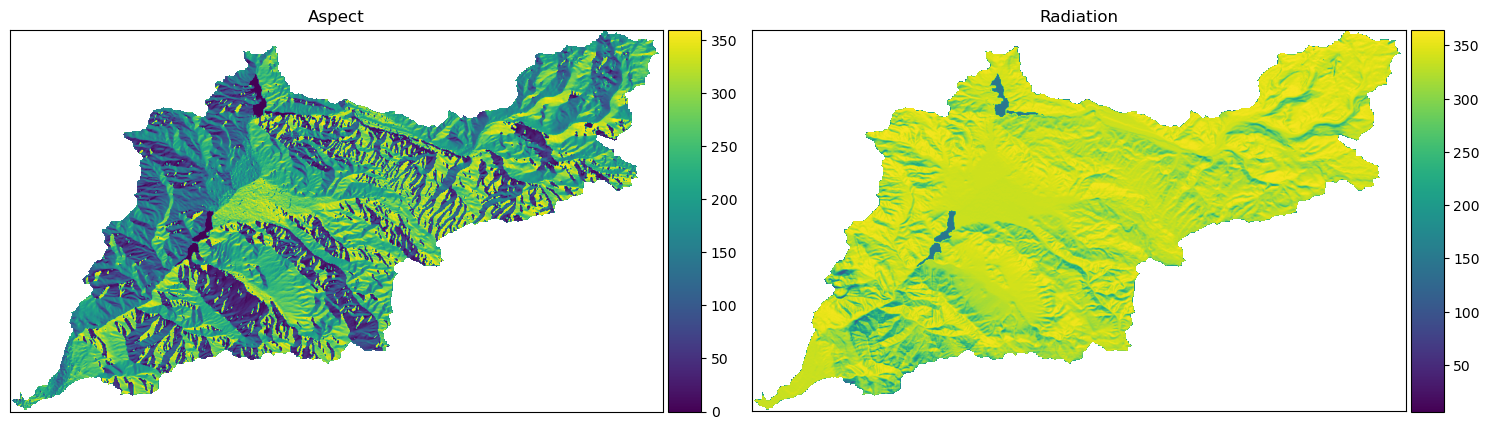

In [9]:
plt.clf()
def read_raster(file):   
    with rio.open(file) as ff:
        data  = ff.read(1)
        mask  = ff.read_masks(1)
    data_ma   = np.ma.masked_array(data, mask==0)
    return data_ma

def plot_locatable_axes(data, ax):
    # reference: https://matplotlib.org/stable/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    divider = make_axes_locatable(ax)
    ax_cb   = divider.new_horizontal(size="5%", pad=0.05)
    fig     = ax.get_figure()
    fig.add_axes(ax_cb)

    im = ax.imshow(data)
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()
    
    # Turn off the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.figure()
f, ax = plt.subplots(1,2, figsize=(15,15)) 

asp_ma = read_raster(basin_aspect_raster)
plot_locatable_axes(asp_ma, ax[0])
ax[0].set_title('Aspect')

sw_ma = read_raster(basin_radiation_raster)
plot_locatable_axes(sw_ma, ax[1])
ax[1].set_title('Radiation')

plt.tight_layout()
plt.show()

f.savefig(os.path.join(plot_path, '4_aspect_radiation.png'), dpi=150, bbox_inches='tight')